In [5]:
import os
import sys
import argparse
import traceback


import logging
import numpy as np
import pandas as pd


# from cmbnet.preprocessing.loading.
import pandas as pd
import cmbnet.utils.utils_plotting as utils_plotting
import cmbnet.utils.utils_general as utils_gen
import cmbnet.preprocessing.datasets.cerebriu as cerebriu

import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy
from tqdm import tqdm

### Load all studies  data

In [6]:
all_scans = pd.read_csv("../../data-misc/csv/ALL_studies.csv")
all_scans.columns

Index(['seriesUID', 'series', 'n_CMB_new', 'seq_type', 'res_level', 'healthy',
       'healthy_all', 'field_strength', 'TE', 'subject', 'patientUID',
       'Dataset', 'n_CMB_old', 'old_shape', 'new_shape', 'old_voxel_dim',
       'new_voxel_dim', 'old_orientation', 'new_orientation', 'studyUID_old',
       'n_indataset', 'newCMB', 'diffCMB', 'nCMB_avg', 'CMB_level'],
      dtype='object')

### Generate CMB metadata

In [7]:
data_dirs = [f'/storage/evo1/jorge/datasets/cmb/{d}/Data' for d in ['cmb_train', 'cmb_dou', 'cmb_crb']]

# CRB specific paths
rawdir = "/storage/evo1/jorge/datasets/cmb/raw/CEREBRIU"
processed_dir = "/storage/evo1/jorge/datasets/cmb/processed/CRB/Data"
reprocessed_dir = "/storage/evo1/jorge/datasets/cmb/processed_final/CRB/Data"

# Load all metadata
metadata_CMBs = {}
for d_dir in data_dirs:
    studies = [s for s in os.listdir(d_dir) if os.path.isdir(os.path.join(d_dir, s))]
    for s in studies:
        metadata_CMBs[s] = utils_gen.get_metadata_from_cmb_format(data_dir=d_dir, sub_id=s)

cmb_metadata = []

for serieuid, met_s in tqdm(metadata_CMBs.items()):
    cmb_new_meta = deepcopy(met_s['CMBs_new'])
    
    for id_num, cmb_meta in cmb_new_meta.items():
        if serieuid.startswith("CRB-"):
            subject_id = all_scans[all_scans['seriesUID'] == serieuid]['subject'].values[0]
            cmb_meta_rich = cerebriu.enrich_reprocessmetadata_with_processed(
                subject_id,
                rawdir,
                processed_dir,
                reprocessed_dir
            )
            cmb_meta = cmb_meta_rich['CMBs_new'][id_num]
        
        cmb_row = {
            "seriesUID": serieuid,
            "cmb_id": id_num,
            **deepcopy(cmb_meta)  # Ensure changes to cmb_row do not affect original cmb_meta
        }
        
        cmb_metadata.append(cmb_row)

df_cmb_metadata = pd.DataFrame(cmb_metadata)

FileNotFoundError: [Errno 2] No such file or directory: '/storage/evo1/jorge/datasets/cmb/cmb_train/Data'

In [ ]:
# # Expand attributes from RB
# df_cmb_metadata['RB_metadata'] = df_cmb_metadata['RB_metadata'].apply(lambda x: x.get('attributes', {}) if isinstance(x, dict) else {})
# attributes_df = df_cmb_metadata['RB_metadata'].apply(pd.Series)
# df_cmb_metadata.drop('RB_metadata', axis=1, inplace=True)
# df_cmb_metadata = pd.concat([df_cmb_metadata, attributes_df], axis=1)


In [ ]:
# # Add metadata study-level
# df_cmb_metadata = (df_cmb_metadata
#     .pipe(lambda df: pd.merge(df, all_scans[['seriesUID', 'seq_type', 'res_level', 'field_strength', 'TE', 'subject', 'patientUID', 'Dataset']], on='seriesUID', how='left'))
# )

In [ ]:
# df_cmb_metadata[~df_cmb_metadata['RB_label'].isnull()].head()

In [ ]:
# df_cmb_metadata['Location'].value_counts()


In [ ]:
# df_cmb_metadata['Dataset'].value_counts()

In [ ]:
# df_cmb_metadata.to_csv("../../data-misc/csv/CMB_metadata_all.csv", index=False)

# CMB analysis

In [ ]:
def calculate_sphere_radius(n_voxels, voxel_spacing):
    voxel_volume = voxel_spacing**3  # Volume of a single voxel
    total_volume = n_voxels * voxel_volume  # Total volume of the sphere
    # Calculate the radius from the volume
    radius = ((3 * total_volume) / (4 * np.pi))**(1/3)
    return radius

In [ ]:
df_cmb_metadata = pd.read_csv("../../data-misc/csv/CMB_metadata_all.csv")
df_cmb_metadata.columns
df_cmb_metadata['radius'] = df_cmb_metadata['size'].apply(lambda x: calculate_sphere_radius(x, 0.5))

/tmp/ipykernel_3669419/1031522685.py:1: DtypeWarning: Columns (7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cmb_metadata = pd.read_csv("../../data-misc/csv/CMB_metadata_all.csv")


In [ ]:
df_cmb_metadata

,seriesUID,cmb_id,CM,size,radius,processed_id,RB_label,Location,Multiple,<5mm,Cause,Uncertain,Other,seq_type,res_level,field_strength,TE,subject,patientUID,Dataset
0,sMOMENI-264_T0_V3-sCMB-10,0,"[48, 127, 164]",116,1.512724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SWI,low,3,20.0,264_T0_MRI_SWI_BFC_50mm_HM_sCMB_V3,264mom,sMOMENI
1,sMOMENI-264_T0_V3-sCMB-10,1,"[69, 79, 194]",116,1.512724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SWI,low,3,20.0,264_T0_MRI_SWI_BFC_50mm_HM_sCMB_V3,264mom,sMOMENI
2,sMOMENI-264_T0_V3-sCMB-10,2,"[116, 116, 60]",108,1.477118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SWI,low,3,20.0,264_T0_MRI_SWI_BFC_50mm_HM_sCMB_V3,264mom,sMOMENI
3,sMOMENI-264_T0_V3-sCMB-10,3,"[131, 59, 94]",98,1.430043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SWI,low,3,20.0,264_T0_MRI_SWI_BFC_50mm_HM_sCMB_V3,264mom,sMOMENI
4,sMOMENI-264_T0_V3-sCMB-10,4,"[163, 64, 192]",56,1.186688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SWI,low,3,20.0,264_T0_MRI_SWI_BFC_50mm_HM_sCMB_V3,264mom,sMOMENI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37764,CRB-1.2.826.1.3680043.9.5282.150415.650.650232...,12,"[236, 146, 107]",187,1.773731,11.0,1.0,Cortex / grey-white junction,True,True,Other,NaN,NaN,T2S,high,1.5/3,32.5,1.2.826.1.3680043.9.5282.150415.650.650232327158,1.2.826.1.3680043.9.5282.150415.650.650232327158,CRB
37765,CRB-1.3.12.2.1107.5.2.6.24111.3000001908210412...,0,"[57, 226, 153]",88,1.379647,2.0,3.0,Cortex / grey-white junction,NaN,True,CAA,True,NaN,SWI,low,1.5/3,32.5,1.3.12.2.1107.5.2.6.24111.30000019082104124198...,1.3.12.2.1107.5.2.6.24111.30000019082104124198...,CRB
37766,CRB-1.3.12.2.1107.5.2.6.24111.3000001908210412...,1,"[122, 256, 158]",143,1.622006,3.0,4.0,Basal ganglia grey matter,NaN,True,Other,NaN,uncertain,SWI,low,1.5/3,32.5,1.3.12.2.1107.5.2.6.24111.30000019082104124198...,1.3.12.2.1107.5.2.6.24111.30000019082104124198...,CRB
37767,CRB-1.3.12.2.1107.5.2.6.24111.3000001908210412...,2,"[149, 282, 234]",125,1.550876,0.0,1.0,Cortex / grey-white junction,NaN,True,Other,True,uncertain,SWI,low,1.5/3,32.5,1.3.12.2.1107.5.2.6.24111.30000019082104124198...,1.3.12.2.1107.5.2.6.24111.30000019082104124198...,CRB


In [ ]:
def filter_iqr(data, column, group_column):
    # Calculate Q1 and Q3 and the IQR
    Q1 = data.groupby(group_column)[column].quantile(0.25)
    Q3 = data.groupby(group_column)[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for filtering
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Apply filtering
    filtered_data = data.apply(
        lambda x: x[column] >= lower_bound[x[group_column]] and x[column] <= upper_bound[x[group_column]],
        axis=1
    )
    
    return data[filtered_data]

/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

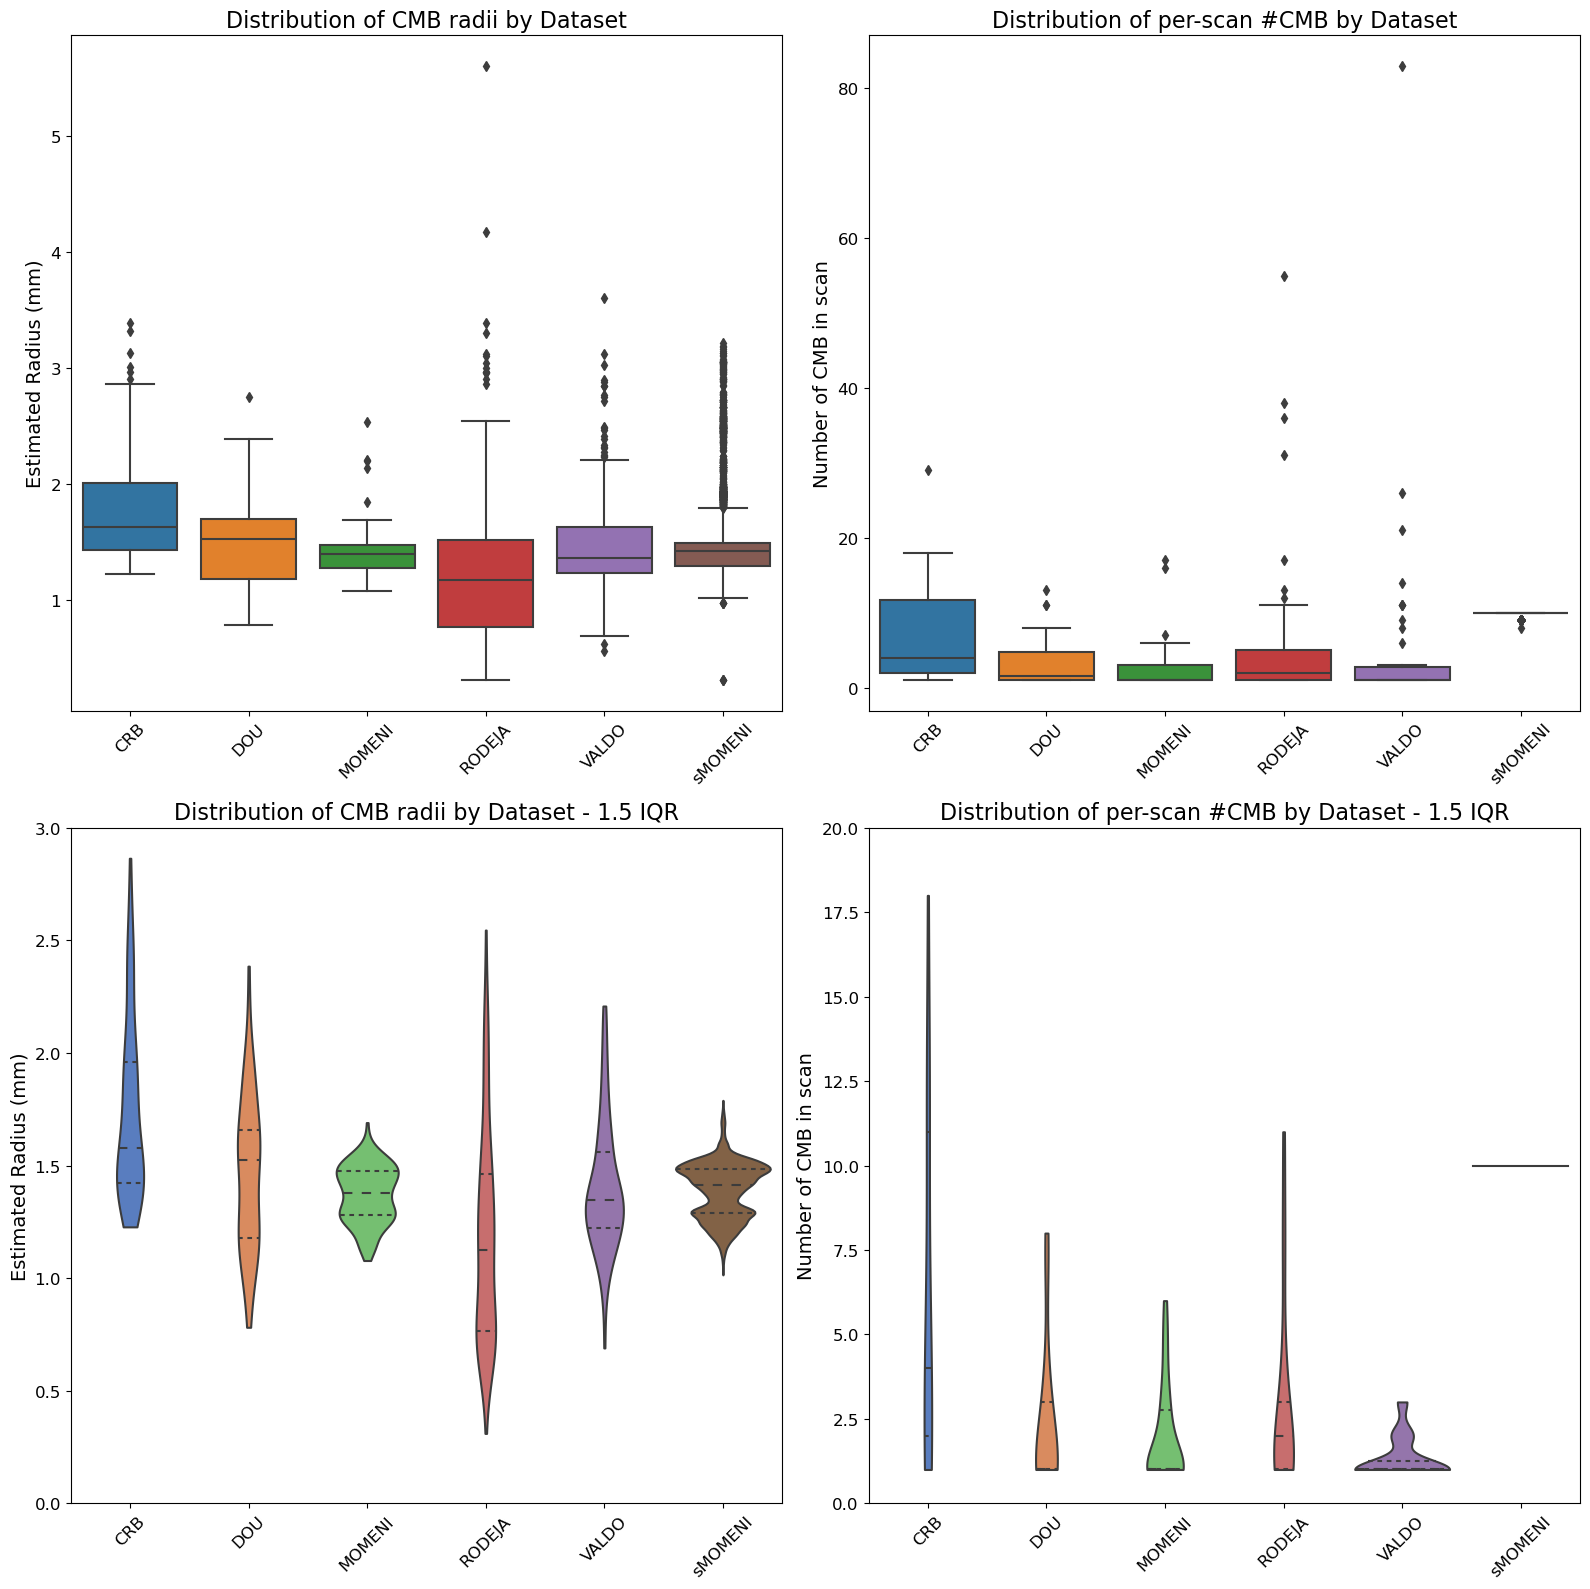

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))  # 1 row, 2 columns


utils_plotting.create_boxplot(
    data=df_cmb_metadata.sort_values('Dataset'),
    column='radius',
    group_by='Dataset',
    ax=axs[0, 0],
    title='Distribution of CMB radii by Dataset',
    xlabel='',
    ylabel='Estimated Radius (mm)'
)

utils_plotting.create_boxplot(
    data=all_scans[all_scans['healthy'] == "no"].sort_values('Dataset'),
    column='n_CMB_new',
    group_by='Dataset',
    ax=axs[0, 1],
    title='Distribution of per-scan #CMB by Dataset',
    xlabel='',
    ylabel='Number of CMB in scan'
)


df_cmb_metadata_filtered = filter_iqr(df_cmb_metadata, 'radius', 'Dataset')
all_scans_filtered = filter_iqr(all_scans[all_scans['healthy'] == "no"], 'n_CMB_new', 'Dataset')

utils_plotting.create_violin_plot(
    data=df_cmb_metadata_filtered.sort_values('Dataset'),
    column='radius',
    group_by='Dataset',
    ax=axs[1, 0],
    title='Distribution of CMB radii by Dataset - 1.5 IQR',
    xlabel='',
    ylabel='Estimated Radius (mm)',
    cut=0,
    y_lim=(0,3)
)

utils_plotting.create_violin_plot(
    data=all_scans_filtered.sort_values('Dataset'),
    column='n_CMB_new',
    group_by='Dataset',
    ax=axs[1, 1],
    title='Distribution of per-scan #CMB by Dataset - 1.5 IQR',
    xlabel='',
    ylabel='Number of CMB in scan',
    cut=0,
    y_lim=(0, 20 )
)

# Adjust layout and display plot
plt.tight_layout()
plt.savefig("../../data-misc/img/CMB_radii_and_counts_by_dataset.png")
plt.show()

# Scans analysis

In [ ]:
all_scans.head()

,seriesUID,series,n_CMB_new,seq_type,res_level,healthy,healthy_all,field_strength,TE,subject,...,old_voxel_dim,new_voxel_dim,old_orientation,new_orientation,studyUID_old,n_indataset,newCMB,diffCMB,nCMB_avg,CMB_level
0,RODEJA-00001-CMB-2,00001-CMB,2,SWI,high,no,False,1.5/3,NaN,00001,...,"[0.2994791567325592, 0.2994791567325592, 2.999...","[0.5, 0.5, 0.5]","['R', 'A', 'S']","['R', 'A', 'S']",00001,1,False,False,2.0,low
1,RODEJA-00003-H,00003-H,0,SWI,high,yes,True,1.5/3,NaN,00003,...,"[0.2994791567325592, 0.2994791567325592, 6.0]","[0.5, 0.5, 0.5]","['R', 'A', 'S']","['R', 'A', 'S']",00003,2,False,False,0.0,NaN
2,RODEJA-00004-H,00004-H,0,SWI,high,yes,True,1.5/3,NaN,00004,...,"[0.2994791567325592, 0.2994791567325592, 1.0]","[0.5, 0.5, 0.5]","['R', 'A', 'S']","['R', 'A', 'S']",00004,3,False,False,0.0,NaN
3,RODEJA-00006-CMB-55,00006-CMB,55,SWI,low,no,False,1.5/3,NaN,00006,...,"[0.8984375, 0.8984375, 2.0]","[0.5, 0.5, 0.5]","['R', 'A', 'S']","['R', 'A', 'S']",00006,4,False,False,55.0,high
4,RODEJA-00007-CMB-2,00007-CMB,2,SWI,high,no,False,1.5/3,NaN,00007,...,"[0.2994791567325592, 0.2994791567325592, 6.0]","[0.5, 0.5, 0.5]","['R', 'A', 'S']","['R', 'A', 'S']",00007,5,False,False,2.0,low


In [ ]:
grouped_scanlevel = (
    all_scans.groupby(["Dataset"])
    .agg(
        n_patients=pd.NamedAgg(column="patientUID", aggfunc=lambda x: x.nunique()),
        n_patients_cmb=pd.NamedAgg(
            column="patientUID",
            aggfunc=lambda x: x[all_scans["healthy"] == "no"].nunique(),
        ),
        n_scans=pd.NamedAgg(column="seriesUID", aggfunc="nunique"),
        n_scans_cmb=pd.NamedAgg(
            column="seriesUID",
            aggfunc=lambda x: x[all_scans.loc[x.index, "healthy"] == "no"].nunique(),
        ),
        n_scans_low_cmb=pd.NamedAgg(
            column="CMB_level",
            aggfunc=lambda x: (
                (all_scans.loc[x.index, "healthy"] == "no") & (x == "low")
            ).sum(),
        ),
        n_scans_low_res=pd.NamedAgg(
            column="res_level",
            aggfunc=lambda x: (
                (all_scans.loc[x.index, "healthy"] == "no") & (x == "low")
            ).sum(),
        ),
        nCMB=pd.NamedAgg(column="n_CMB_new", aggfunc="sum"),
        nCMB_perscan_avg=pd.NamedAgg(
            column="n_CMB_new",
            aggfunc=lambda x: (
                mean := x[all_scans.loc[x.index, "healthy"] == "no"].mean(),
                round(mean, 2) if pd.notna(mean) else None,
            )[1],
        ),
        nCMB_perscan_std=pd.NamedAgg(
            column="n_CMB_new",
            aggfunc=lambda x: round(
                x[all_scans.loc[x.index, "healthy"] == "no"].std(), 2
            ),
        ),
        perc_scans_low_res=pd.NamedAgg(
            column="res_level",
            aggfunc=lambda x: round(100 * (x == "low").sum() / len(x)),
        ),
    )
    .reset_index()
)

grouped_cmblevel = (
    df_cmb_metadata.groupby(["Dataset"])
    .agg(
        radCMB_avg=pd.NamedAgg(column="radius", aggfunc=lambda x: round(x.mean(), 2)),
        radCMstd=pd.NamedAgg(column="radius", aggfunc=lambda x: round(x.std(), 2)),
    )
    .reset_index()
)


grouped_scanlevel = grouped_scanlevel.pipe(
    lambda df: pd.merge(df, grouped_cmblevel, on="Dataset", how="left")
)
grouped_scanlevel.fillna("-", inplace=True)


outdf = pd.DataFrame()
outdf["Dataset"] = grouped_scanlevel["Dataset"]
outdf["# Scans (total-w/cmb-<3cmb)"] = (
    grouped_scanlevel["n_scans"].astype(str)
    + " - "
    + grouped_scanlevel["n_scans_cmb"].astype(str)
    + " - "
    + grouped_scanlevel["n_scans_low_cmb"].astype(str)
)

outdf["# Patients: (total- w/cmb)"] = (
    grouped_scanlevel["n_patients"].astype(str)
    + " - "
    + grouped_scanlevel["n_patients_cmb"].astype(str)
)

outdf["Res. level % (low-high)"] = (
    grouped_scanlevel["perc_scans_low_res"].astype(str)
    + " - "
    + (100 - grouped_scanlevel["perc_scans_low_res"]).astype(str)
)
outdf["Total CMBs"] = grouped_scanlevel["nCMB"]
outdf["Avg #CMB per-scan"] = (
    grouped_scanlevel["nCMB_perscan_avg"].astype(str)
    + " ± "
    + grouped_scanlevel["nCMB_perscan_std"].astype(str)
)
outdf["CMB radius avg (mm)"] = (
    grouped_scanlevel["radCMB_avg"].astype(str)
    + " ± "
    + grouped_scanlevel["radCMstd"].astype(str)
)


outdf["availability"] = [
    "private",
    "private",
    "public",
    "public",
    "private",
    "public",
    "public",
]

outdf["split"] = [
    "test",
    "train",
    "test",
    "train-valid",
    "train-valid",
    "train-valid",
    "train",
]
outdf.sort_values("Dataset", inplace=True)
outdf.to_csv(
    "../../data-misc/csv/CMB_dataset_summary.csv", index=False, sep=";", quotechar='"'
)
outdf

/tmp/ipykernel_3669419/2244031714.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  grouped_scanlevel.fillna("-", inplace=True)


,Dataset,# Scans (total-w/cmb-<3cmb),# Patients: (total- w/cmb),Res. level % (low-high),Total CMBs,Avg #CMB per-scan,CMB radius avg (mm),availability,split
0,CRB,18 - 18 - 8,18 - 18,44 - 56,127,7.06 ± 7.53,1.8 ± 0.49,private,test
1,CRBneg,742 - 0 - 0,742 - 0,40 - 60,0,- ± -,- ± -,private,train
2,DOU,20 - 20 - 14,20 - 20,0 - 100,74,3.7 ± 3.99,1.48 ± 0.37,public,test
3,MOMENI,370 - 57 - 46,118 - 30,100 - 0,146,2.56 ± 3.09,1.4 ± 0.2,public,train-valid
4,RODEJA,103 - 61 - 42,103 - 61,15 - 85,357,5.85 ± 10.08,1.26 ± 0.63,private,train-valid
5,VALDO,72 - 50 - 40,72 - 50,38 - 62,253,5.06 ± 12.41,1.5 ± 0.46,public,train-valid
6,sMOMENI,3700 - 3700 - 0,118 - 118,100 - 0,36812,9.95 ± 0.22,1.41 ± 0.17,public,train


# CMB shapes

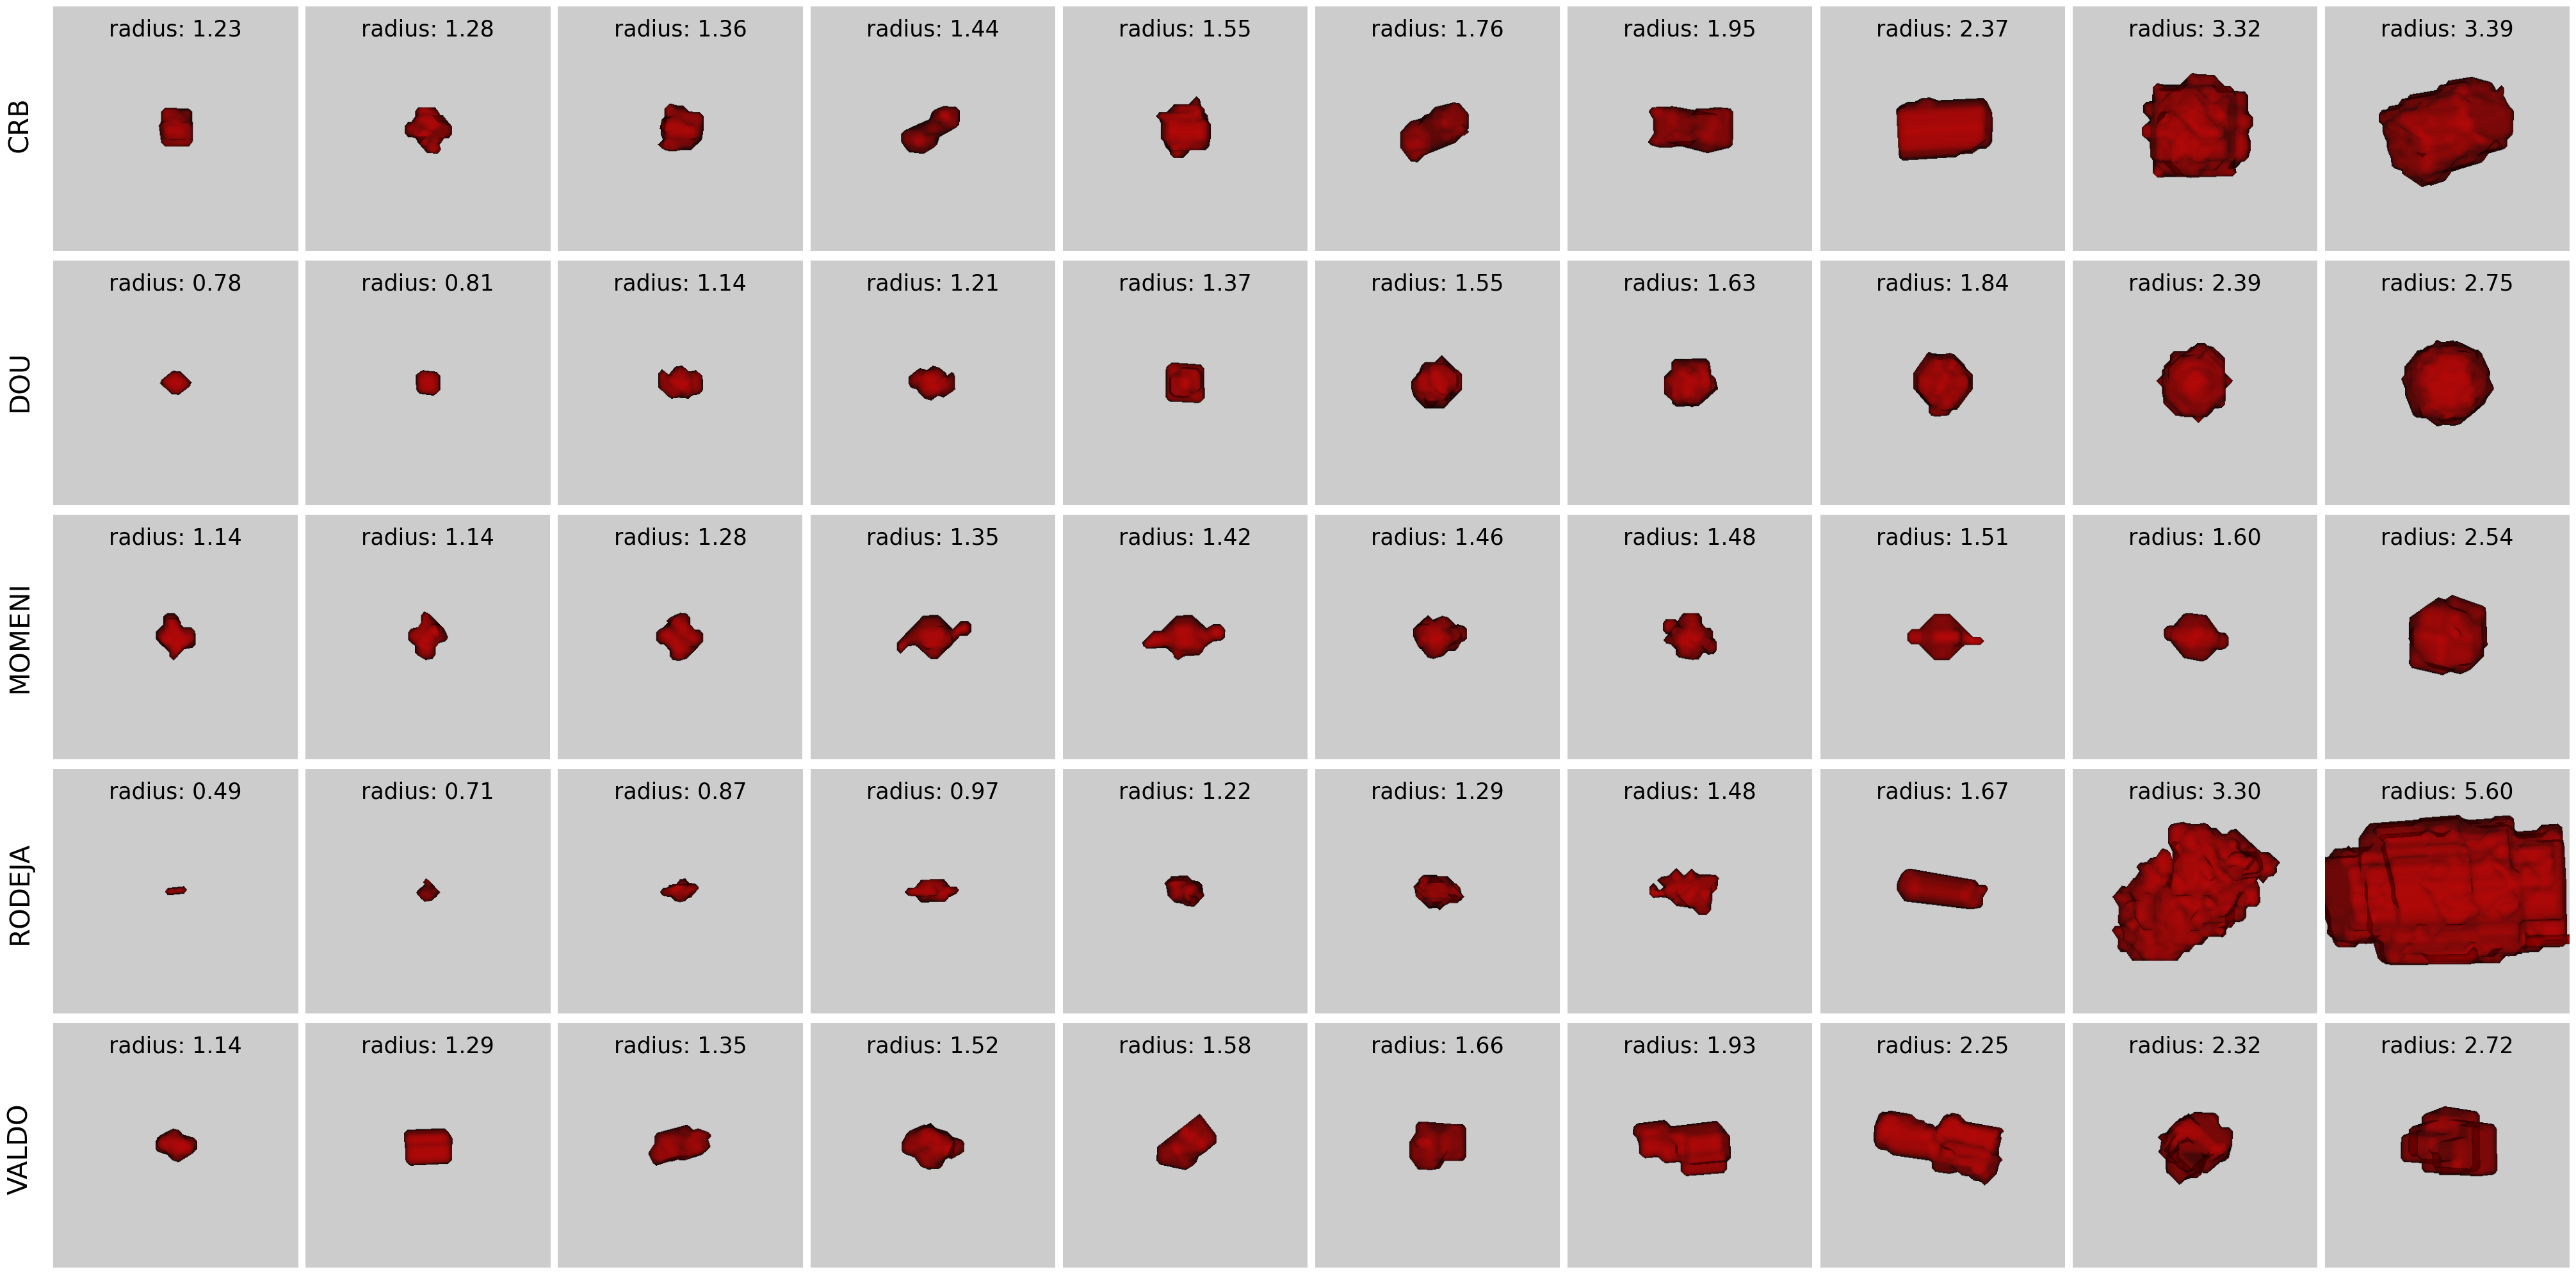

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random

SAMPLE_SIZE = 10
random.seed(42)

# Define the directory where the images are stored
image_dir = "/home/cerebriu/data/MScthesis_data/cmb_3d/GT"
# Collect all PNG image files in the directory
image_files = [file for file in os.listdir(image_dir) if file.endswith(".png")]

# Initialize a dictionary to store images grouped by datasets
dataset_images = {}

# Iterate over each file in the image directory
for image_file in image_files:
    filename_parts = image_file.split("_")
    subject = filename_parts[0]
    cmb = filename_parts[-2]  # Assuming this part is needed later or for completeness
    radius = float(filename_parts[-1].replace(".png", ""))  # Extract and convert radius to float
    dataset = subject.split("-")[0]
    
    # Group images by dataset and include radius for sorting
    if dataset not in dataset_images:
        dataset_images[dataset] = []
    dataset_images[dataset].append((subject, image_file, radius, cmb))

# Ensure a variety of radii sizes for each dataset
for dataset in dataset_images:
    dataset_images[dataset] = sorted(dataset_images[dataset], key=lambda x: x[2])
    radii = np.array([x[2] for x in dataset_images[dataset]])
    if len(radii) > SAMPLE_SIZE:
        # Find indices for smallest and largest radii
        smallest_idx = 0
        largest_idx = len(radii) - 1
        # Distribute remaining slots uniformly
        middle_indices = np.linspace(smallest_idx + 1, largest_idx - 1, SAMPLE_SIZE - 2, dtype=int)
        sampled_indices = [smallest_idx, *middle_indices, largest_idx]
    else:
        sampled_indices = range(len(radii))  # Use all available indices if fewer than SAMPLE_SIZE
    dataset_images[dataset] = [dataset_images[dataset][index] for index in sampled_indices]

# Sort datasets alphabetically
sorted_datasets = sorted(dataset_images.items(), key=lambda x: x[0])

# Determine the number of datasets and the subplot grid size
num_datasets = len(dataset_images)
num_plots_per_row = min(SAMPLE_SIZE, max(len(images) for images in dataset_images.values()))  # At most 12 images per dataset

# Create a figure with subplots
fig, axs = plt.subplots(num_datasets, num_plots_per_row, figsize=(4 * num_plots_per_row, 4 * num_datasets), squeeze=False)

# Adjust space between rows
plt.subplots_adjust(hspace=0.5)  # Adjust horizontal space

# Plot images for each dataset
for row, (dataset, images) in enumerate(sorted_datasets):
    axs[row, 0].set_ylabel(dataset, fontsize=14, rotation=0, labelpad=30)  # Set dataset name as y-axis label for each row
    selected_images = images[:num_plots_per_row]  # Select up to 12 images based on sorted order
    for col, (subject, image_file, radius, cmb) in enumerate(selected_images):
        image_path = os.path.join(image_dir, image_file)
        image = plt.imread(image_path)
        
        axs[row, col].imshow(image)
        axs[row, col].axis("off")  # Hide axes for individual plots
        # Place text at the top inside the plot
        axs[row, col].text(0.5, 0.95, f"radius: {radius:.2f}", fontsize=25, color='black', ha='center', va='top', transform=axs[row, col].transAxes)
    fig.text(0.001, 1 - row / num_datasets - 0.1, dataset, va='center', ha='right', rotation='vertical', fontsize=30)

plt.tight_layout()
plt.savefig("../../data-misc/img/CMB_3D_GT_by_dataset.png", bbox_inches='tight')  # Adjust bounding box to include all content
plt.show()


# CMB shapes of predictions

In [23]:
import os
import matplotlib.pyplot as plt
import random
import hashlib

SAMPLE_SIZE = 45


# Define the directory where the images are stored
image_dir = "/home/cerebriu/data/MScthesis_data/cmb_3d/pred"

# Collect all PNG image files in the directory
image_files = [file for file in os.listdir(image_dir) if file.endswith(".png") and "DOU" not in file]

# Initialize a dictionary to store images grouped by datasets
dataset_images = {}

# Iterate over each file in the image directory
for image_file in image_files:
    filename_parts = image_file.replace("_pred", "").split("_")
    subject = filename_parts[0]
    dataset = subject.split("-")[0]
    if dataset == "CRB":
        filename_parts[0] =  'CRB-' + hashlib.md5(filename_parts[0].encode()).hexdigest()[:5]
    else:
        filename_parts[0] = filename_parts[0].split("-")[0] + '-' + filename_parts[0].split("-")[1]
    base_name = "_".join(filename_parts[:-1])  # Excludes the last part (radius)

    is_pred = '_pred' in image_file
    radius = float(filename_parts[-1].replace(".png", ""))  # Extract and convert radius to float

    # Group images by dataset and include radius for sorting
    if dataset not in dataset_images:
        dataset_images[dataset] = {}
    if base_name not in dataset_images[dataset]:
        dataset_images[dataset][base_name] = {}
    dataset_images[dataset][base_name][is_pred] = (image_file, radius)

# Prepare the dataset images for plotting, ensuring they are sorted by GT radius
balanced_dataset_images = {}
for dataset, base_names in dataset_images.items():
    pred_pairs = []
    non_pred_images = []
    for base_name, versions in base_names.items():
        non_pred_version = versions.get(False, None)
        pred_version = versions.get(True, None)
        if non_pred_version and pred_version:
            pred_pairs.append((base_name, non_pred_version, pred_version))
        elif non_pred_version:
            non_pred_images.append((base_name, non_pred_version))
    
    # Randomly sample up to 10 images from each category
    random.seed(42)  # Ensure reproducibility
    sampled_pred_pairs = random.sample(pred_pairs, min(len(pred_pairs), SAMPLE_SIZE))
    sampled_non_pred_images = random.sample(non_pred_images, min(len(non_pred_images), SAMPLE_SIZE))

    # Re-sort the sampled images by GT radius
    final_samples = sampled_pred_pairs + [(name, img, None) for name, img in sampled_non_pred_images]
    final_samples.sort(key=lambda x: x[1][1])  # Sort by non-pred radius

    balanced_dataset_images[dataset] = final_samples

# Determine the maximum number of images to plot per dataset
max_images_per_dataset = 2*SAMPLE_SIZE  # Since we are displaying 10 of each type

# Create a figure with subplots
fig, axs = plt.subplots(len(balanced_dataset_images) * 2, max_images_per_dataset, figsize=(4 * max_images_per_dataset, 10 * len(balanced_dataset_images)), squeeze=False)

# Plot images for each dataset
for row_index, (dataset, image_infos) in enumerate(balanced_dataset_images.items()):
    for col, (base_name, non_pred_image, pred_image) in enumerate(image_infos):
        # Plot non-pred image
        if non_pred_image:
            non_pred_path = os.path.join(image_dir, non_pred_image[0])
            non_pred_img = plt.imread(non_pred_path)
            axs[2 * row_index, col].imshow(non_pred_img)
            axs[2 * row_index, col].text(0.5, 0.95, f"radius: {non_pred_image[1]:.2f}", fontsize=25, color='black', ha='center', va='top', transform=axs[2 * row_index, col].transAxes)

        axs[2 * row_index, col].axis('off')

        # Plot pred image if available
        if pred_image:
            pred_path = os.path.join(image_dir, pred_image[0])
            pred_img = plt.imread(pred_path)
            axs[2 * row_index + 1, col].imshow(pred_img)
            axs[2 * row_index + 1, col].text(0.5, 0.95, f"radius: {pred_image[1]:.2f}", fontsize=25, color='black', ha='center', va='top', transform=axs[2 * row_index + 1, col].transAxes)

        axs[2 * row_index + 1, col].axis('off')
        
        
    fig.text(0.001, 1 - row / num_datasets - 0.1, dataset, va='center', ha='right', rotation='vertical', fontsize=30)

plt.tight_layout()
plt.savefig("/home/cerebriu/Downloads/EXAMPLES/DOU_CMBs_3D_comparison_balanced_sorted.png")
plt.show()